In [29]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
from msal import PublicClientApplication

from cognite.client import CogniteClient
from cognite.client.data_classes import TimeSeries, Asset

import matplotlib.pyplot as plt

# Log-in detaljer
TENANT_ID = os.getenv("AZURE_TENANT_ID")
CLIENT_ID = os.getenv("AZURE_CLIENT_ID")
CDF_CLUSTER = "az-power-no-northeurope"
COGNITE_PROJECT = "heco-dev"

# Code to log-in WIHTOUT client_secret
SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000


def authenticate_azure():

    app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)

    # interactive login - make sure you have http://localhost:port in Redirect URI in App Registration as type "Mobile and desktop applications"
    creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)
    return creds


creds = authenticate_azure()

client = CogniteClient(
    token_url=creds["id_token_claims"]["iss"],
    token=creds["access_token"],
    token_client_id=creds["id_token_claims"]["aud"],
    project=COGNITE_PROJECT,
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
    client_name="cognite-python-dev",
)

In [30]:
# Defining curves
curves = ["NO1_consumption_per_15min",
# "NO1_el_price_per_hour",
# "NO1_temperature_per_15min",
"NO1_cloud_coverage_per_15min",
# "NO1_consumption_forecast_per_15min"
]

# Defining relevant dates
start_date = datetime(2022,1,1)
end_date = datetime(2022,1,2)

df_watt = pd.DataFrame()
for curve in curves:
    print(curve)
    hm = client.datapoints.retrieve_dataframe(
        start=start_date,
        end=end_date,
        aggregates=["average"],
        granularity="1h",
        id=client.time_series.retrieve(external_id=curve).id,)
    df_watt = pd.merge(df_watt, hm, left_index=True, right_index=True, how="outer")

df_watt.columns = ["cons_actual","cc_forecast"]

NO1_consumption_per_15min
NO1_cloud_coverage_per_15min


In [31]:
df_watt['Seconds'] = df_watt.index.map(pd.Timestamp.timestamp)
day = 60*60*24
# year = 365.2425*day
# week = day*7

df_watt['Day sin'] = np.sin(df_watt['Seconds'] * (2* np.pi / day))
df_watt['Day cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / day))
# df_watt['Week sin'] = np.sin(df_watt['Seconds'] * (2 * np.pi / week))
# df_watt['Week cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / week))
# df_watt['Year sin'] = np.sin(df_watt['Seconds'] * (2 * np.pi / year))
# df_watt['Year cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / year))

df_watt=df_watt.drop(['Seconds'], axis=1)
df_watt

,cons_actual,cc_forecast,Day sin,Day cos
2022-01-01 00:00:00,4698.500,0.69625,-8.652299e-12,1.000000e+00
2022-01-01 01:00:00,4673.375,0.86250,2.588190e-01,9.659258e-01
2022-01-01 02:00:00,4623.125,0.75000,5.000000e-01,8.660254e-01
2022-01-01 03:00:00,4648.125,0.83875,7.071068e-01,7.071068e-01
2022-01-01 04:00:00,4686.500,0.97375,8.660254e-01,5.000000e-01
2022-01-01 05:00:00,4811.625,1.00000,9.659258e-01,2.588190e-01
2022-01-01 06:00:00,4899.250,1.00000,1.000000e+00,1.121564e-11
2022-01-01 07:00:00,5053.125,1.00000,9.659258e-01,-2.588190e-01
2022-01-01 08:00:00,5159.625,1.00000,8.660254e-01,-5.000000e-01
2022-01-01 09:00:00,5327.500,1.00000,7.071068e-01,-7.071068e-01


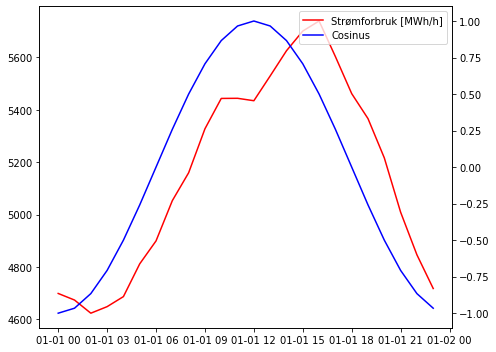

In [40]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot()
l1, = ax1.plot(df_watt["cons_actual"],color="red")
ax2 = ax1.twinx()
l2, = ax2.plot(-df_watt["Day cos"],color="blue")

plt.legend([l1,l2],["Strømforbruk [MWh/h]","Cosinus"])
plt.show()

# plt.plot(df_watt.index,df_watt["cc_forecast"])
# plt.plot(df_watt.index,df_watt["cons_actual"])